In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interpolate
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pickle
import time
import numpy as np
import pandas as pd
import ppscore as pps
import os
from collections import Counter
# Load Data Imports
import load_data as ld
import data_columns as dc
import numpy as np
import matplotlib.pyplot as plt
#print(plt.rcParams.keys())
plt.rcParams.update({'font.size': 20,
                     'xtick.labelsize' : 20,
                     'ytick.labelsize' : 20,
                     'axes.labelsize': 20,
                     'legend.fontsize': 20})
plt.rc('font',**{'family':'serif','serif':['Times']})
color1= '#94b4a4'
color2='#deebf7'
color3='#fff7bc'
# give more descriptive names for the features
COLS = ['Last #seg.', 'Last bitrate', 'Seg. thput', 'Window thput',
             'Buffered Bytes', 'Buffered #seg.', 
             'DL RSRP', 'DL SINR', 
             'DL MCS', 'DL thput', 'Next bitrate']

In [8]:
PARAMETERS = {
    'aggr_wind_size': '12', # ['4', '8', '12', '16']
    'horz_wind_size': '2'}
    
train_data_dir = '../data/data_train/dataset7-' \
                                + PARAMETERS['horz_wind_size'] + 'sWsize-' \
                                + PARAMETERS['aggr_wind_size'] + 'aggsize/'
print('Reading datset from: ', train_data_dir)
# load the dataset
df = ld.load_rf_trainer_data(train_data_dir, verbose=False)
df = df.astype('float32')
# keep only the real number values 
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
# columns from the dataset that are input features 
FEAT_COLS = dc.FEAT_COLS
# column from the dataset that is the ground truth label
TARGET_SEGMODE = dc.TARGET_SEGMODE
TARGET_SEGNUMBER = dc.TARGET_SEGNUMBER
# remove the samples for which we do not have ground truth 
df = df.loc[df[TARGET_SEGMODE[0]] > 0.0].copy()
classes_unique = np.unique(df[TARGET_SEGMODE].values)


Reading datset from:  ../data/data_train/modFeat3_dataset7-2sWsize-12aggsize/


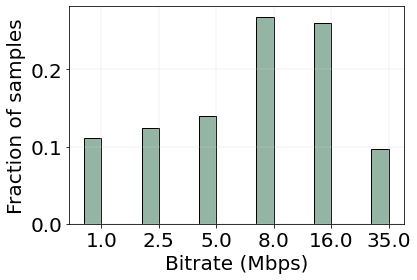

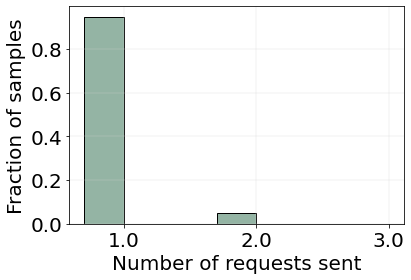

In [9]:
df_class_count = df[TARGET_SEGMODE].to_numpy()
unique, counts = np.unique(df_class_count, return_counts=True)
counts = counts/sum(counts)

df_class_count_nseg = df[TARGET_SEGNUMBER].to_numpy()
unique_nseg, counts_nseg = np.unique(df_class_count_nseg, return_counts=True)
counts_nseg = counts_nseg/sum(counts_nseg)

plt.figure(1)
width = 0.3
brate_bar = np.arange(len(unique)) 
plt.bar(brate_bar, counts, color =color1, 
        width=width, edgecolor ='k', 
        label ='bitrate',align='edge')
plt.ylabel('Fraction of samples')
plt.xlabel('Bitrate (Mbps)')
brate_str = [str(e) for e in unique/1000000 ]
plt.xticks([r + width for r in range(len(counts))], 
           brate_str) 
plt.grid(color='lightgray', linestyle='-', linewidth=0.3)
#plt.legend(loc ="lower right")
plt.show()

plt.figure(2)
width = 0.3
brate_bar = np.arange(len(unique_nseg)) 
plt.bar(brate_bar, counts_nseg, color =color1, 
        width=width, edgecolor ='k', 
        label ='bitrate',align='edge')
plt.ylabel('Fraction of samples')
plt.xlabel('Number of requests sent')
brate_str = [str(e) for e in unique_nseg]
plt.xticks([r + width for r in range(len(counts_nseg))], 
           brate_str) 
plt.grid(color='lightgray', linestyle='-', linewidth=0.3)
#plt.legend(loc ="lower right")
plt.show()

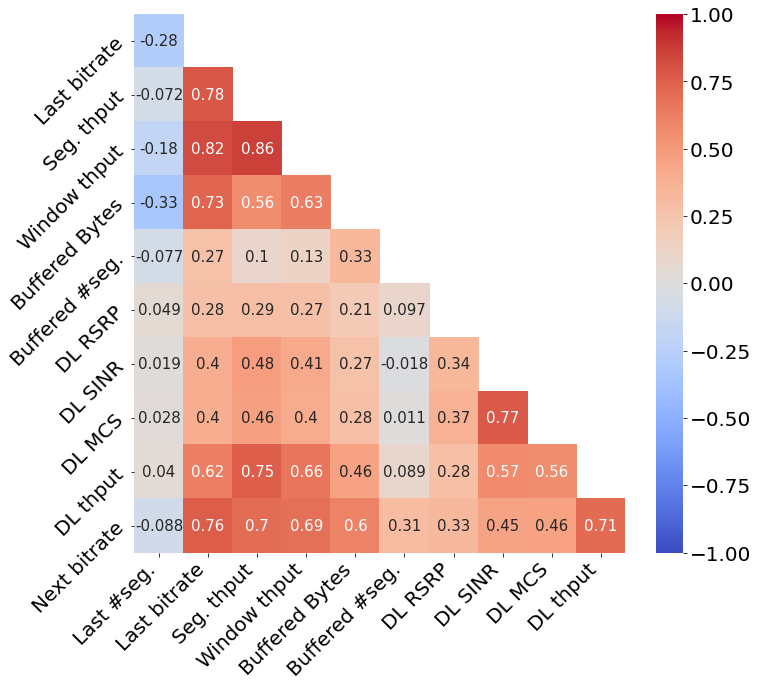

In [13]:
import seaborn as sns
#sns.set(style="ticks")
FEAT_COLS = dc.FEAT_COLS
# column from the dataset that is the ground truth label
TARGET_SEGMODE = dc.TARGET_SEGMODE
df_feats = df[FEAT_COLS].copy()
df_brate = df[TARGET_SEGMODE].copy()
df_for_corr = pd.concat([df_feats, df_brate], axis=1)
df_for_corr.columns = COLS
plt.figure(figsize=(len(df_for_corr.columns),len(df_for_corr.columns)))
df_corr = df_for_corr.corr(method = 'kendall')
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
hmap = sns.heatmap(corr, vmin=-1, cmap='coolwarm', annot=True, mask=mask, 
                   vmax=1, annot_kws={"fontsize":15}, linecolor='black')
fig = hmap.get_figure()
plt.yticks(rotation=45)
fig.autofmt_xdate(rotation=45)
plt.show()